# Modeling listing prices

In this notebook, we will use different approaches to model listing price. The target variable in this notebook is the `price` column in our cleaned data. 

In [58]:
# imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

# sklearn
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
df = pd.read_csv('./../data/austin_listings_clean.csv').drop(columns=['occupancy_rate'])
df.head(5)

,bedrooms,beds,bath,zipcode,host_is_superhost,review_scores_rating,time_quarter,has_pool,is_petfriendly,has_workspace,has_freeparking,has_gym,home_price_aprx,price
0,1,2,1.0,78702,1,4.84,Q4,0,0,0,0,0,613000,101.000000
1,0,1,1.0,78704,0,4.97,Q4,0,0,1,0,0,802000,91.666667
2,1,2,1.0,78704,1,4.97,Q4,0,0,1,1,0,802000,159.000000
3,1,1,1.0,78741,0,4.56,Q4,0,1,0,0,0,397000,48.000000
4,2,2,2.0,78702,1,5.00,Q4,0,0,1,0,0,613000,123.000000


## Correlation between different features

C:\Users\masou\AppData\Local\Temp\ipykernel_20568\2380060807.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = round(df.corr(), 2)


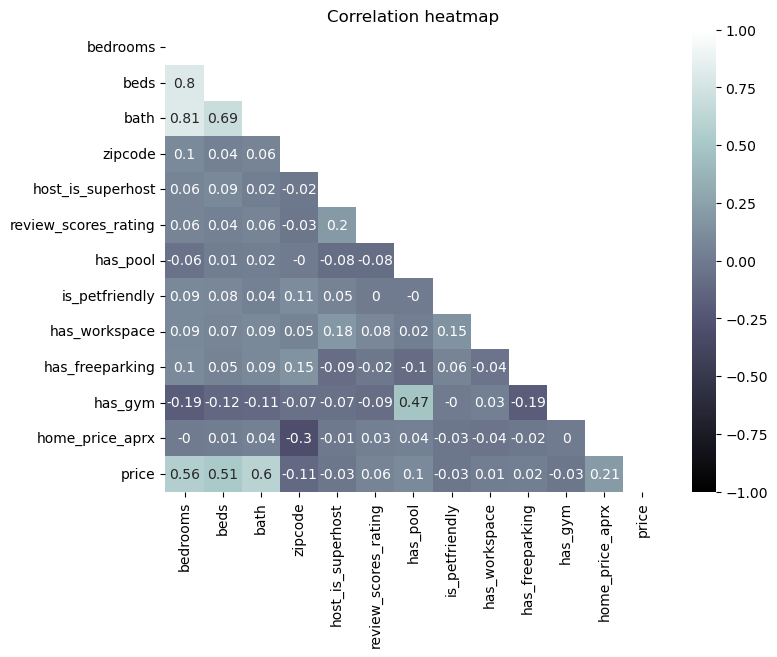

In [4]:
# plot the correlation matrix heatmap
plt.figure(figsize=(8, 6))
corr = round(df.corr(), 2)
mask = np.triu(np.ones_like(corr)) 
sns.heatmap(corr, mask=mask, annot=True, cmap='bone',
            vmin = -1, vmax=1)
plt.title('Correlation heatmap');



From this graph, we can see the listing price shows the highest correlation with bedrooms, baths,and homeprice. Note that categorical features like the time of the listing is not considered here. 

Also, looking at the correlation matrix heatmap, we can say features like beds, bedrooms, and bath are correlated to each other. Another interesting observation is the fact that the houses that have pool are more likely to have gym as well. 

## Null model

We will start our analysis with the null model. For this, the average listing price will be considered as our prediction. 

In [5]:
# create a dataframe for the null model
df_null_model = df.copy()
X = df_null_model.drop(columns=['price'])
y = df_null_model['price']
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2)
pred = y_train.mean()
print(f'predicted price for the null model: ${int(pred)}/night')

predicted price for the null model: $246/night


In [6]:
preds_train = pred*np.ones(len(y_train))
preds_test = pred*np.ones(len(y_test))
print(f'Train data R2 = {r2_score(y_train, preds_train)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {r2_score(y_test, preds_test)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.0
Train data MAE ($) = 152
Test data R2 = -0.0002555833763804305
Test data MAE ($) = 154


__Highlights__:

## Simple linear regression

We will start our modeling by building a simple linear regression model with a few features that seem to have the highest impact on listing price. The featues are `bedrooms`, `beds`, `bath`, `has_pool`, `time_quarter`, and `home_price_aprx`. 

In [55]:
X = df[['bedrooms', 'beds', 'bath', 'has_pool', 'time_quarter', 'home_price_aprx']]
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_time', ohe, ['time_quarter'])    
    ], remainder='passthrough')
# create pipeline
lr_simple_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('lr', LinearRegression())]
) 

# fit the model
lr_simple_pipeline.fit(X_train, y_train)

# predict data
preds_train = lr_simple_pipeline.predict(X_train)
preds_test = lr_simple_pipeline.predict(X_test)

In [56]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.4398
Train data MAE ($) = 110
Test data R2 = 0.4288
Test data MAE ($) = 111


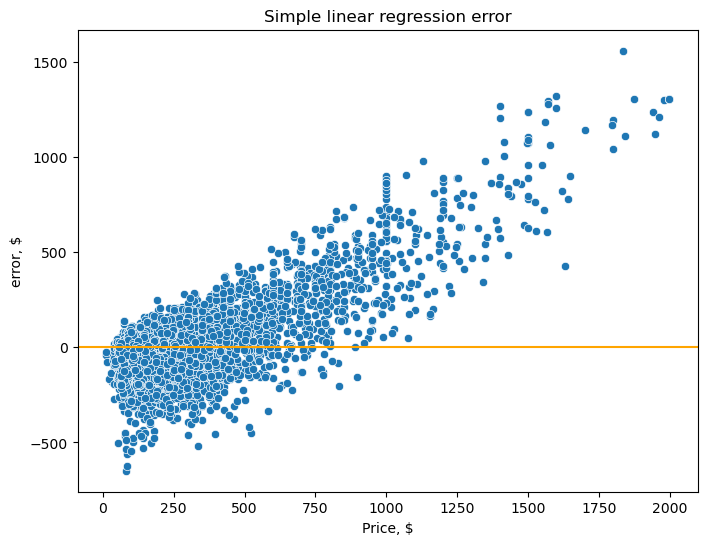

In [57]:
error = y_test - preds_test
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=error)
plt.xlabel('Price, $')
plt.ylabel('error, $')
plt.title('Simple linear regression error')
plt.axhline(0, color='orange');

As we can see, the model shows issues modeling the listing prices. Let us see if adding some polynomial terms could help improce the linear model performance.  

In [71]:
X = df[['bedrooms', 'beds', 'bath', 'has_pool', 'time_quarter', 'home_price_aprx']]
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_time', ohe, ['time_quarter'])    
    ], remainder='passthrough')
# create pipeline
lr_simple_poly_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('poly', PolynomialFeatures(degree=2)), # polynomial feature, quadratic
    ('lr', LinearRegression())]
) 

# fit the model
lr_simple_poly_pipeline.fit(X_train, y_train)

# predict data
preds_train = lr_simple_poly_pipeline.predict(X_train)
preds_test = lr_simple_poly_pipeline.predict(X_test)

# quadratic and first degree interaction terms created
print('New features used in our model:')
lr_simple_poly_pipeline.named_steps['poly'].get_feature_names_out([
            'time_quarter_Q2', 'time_quarter_Q3',
            'time_quarter_Q4', 'bedrooms',
            'beds', 'bath', 'has_pool','home_price_aprx'])


New features used in our model:


array(['1', 'time_quarter_Q2', 'time_quarter_Q3', 'time_quarter_Q4',
       'bedrooms', 'beds', 'bath', 'has_pool', 'home_price_aprx',
       'time_quarter_Q2^2', 'time_quarter_Q2 time_quarter_Q3',
       'time_quarter_Q2 time_quarter_Q4', 'time_quarter_Q2 bedrooms',
       'time_quarter_Q2 beds', 'time_quarter_Q2 bath',
       'time_quarter_Q2 has_pool', 'time_quarter_Q2 home_price_aprx',
       'time_quarter_Q3^2', 'time_quarter_Q3 time_quarter_Q4',
       'time_quarter_Q3 bedrooms', 'time_quarter_Q3 beds',
       'time_quarter_Q3 bath', 'time_quarter_Q3 has_pool',
       'time_quarter_Q3 home_price_aprx', 'time_quarter_Q4^2',
       'time_quarter_Q4 bedrooms', 'time_quarter_Q4 beds',
       'time_quarter_Q4 bath', 'time_quarter_Q4 has_pool',
       'time_quarter_Q4 home_price_aprx', 'bedrooms^2', 'bedrooms beds',
       'bedrooms bath', 'bedrooms has_pool', 'bedrooms home_price_aprx',
       'beds^2', 'beds bath', 'beds has_pool', 'beds home_price_aprx',
       'bath^2', 'bath has_p

In [72]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.4825
Train data MAE ($) = 101
Test data R2 = 0.4669
Test data MAE ($) = 103


We can see using polynomial features has slightly improved the performance of our linear regression. 

__Highlights:__
- By using some of the most important features and interaction terms in linear regression, we can achieve an R2 of 0.47.

## Linear regression (with all features)

In  this case, we will use a simple linear regression model to predict the house price. Note that there are multiple categorical features (zipcode and time of the listing) that needs to be onehot encoded. We will use a pipeline to chain multiple operations. 

In [73]:
X = df.drop(columns=['price'])
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_zip', ohe, ['zipcode']),
        ('ohe_time', ohe, ['time_quarter'])    
    ], remainder='passthrough')
# create pipeline
lr_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('lr', LinearRegression())]
) 

# fit the model
lr_pipeline.fit(X_train, y_train)

# predict data
preds_train = lr_pipeline.predict(X_train)
preds_test = lr_pipeline.predict(X_test)



In [74]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.4715
Train data MAE ($) = 107
Test data R2 = 0.4599
Test data MAE ($) = 110


As we can see, the model is performing just ok. Let us take a look at the errors to see where we are standing. 

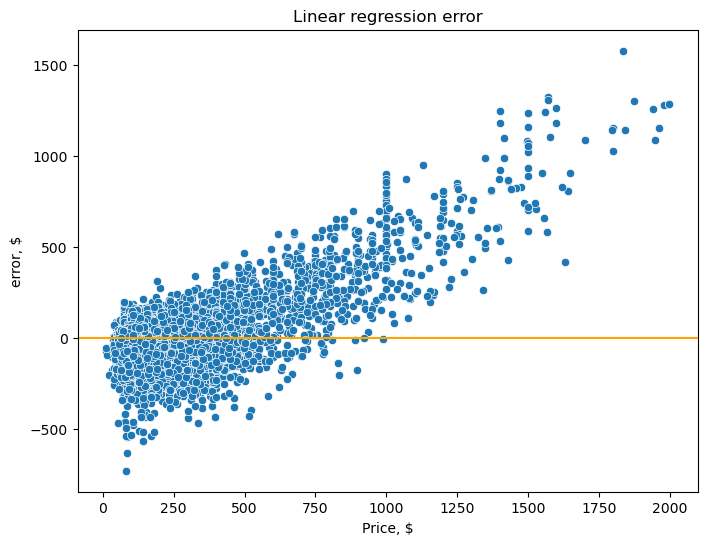

In [9]:
error = y_test - preds_test
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=error)
plt.xlabel('Price, $')
plt.ylabel('error, $')
plt.title('Linear regression error')
plt.axhline(0, color='orange');

We can see that for higher prices the error becomes larger. We will try to see if we can help with this issue by doing a log tranform of the price variable but before that, let us take a look at the coefficients of the linear regression. 

In [51]:
pd.DataFrame(zip(lr_pipeline.named_steps['ohe_cols'].get_feature_names_out(),lr_pipeline.named_steps['lr'].coef_ ), columns=['feature', 'coef'])

,feature,coef
0,ohe_zip__zipcode_78702,-1.066628e+14
1,ohe_zip__zipcode_78703,3.353587e+14
2,ohe_zip__zipcode_78704,7.748014e+13
3,ohe_zip__zipcode_78705,-1.913702e+14
4,ohe_zip__zipcode_78717,-1.870031e+13
5,ohe_zip__zipcode_78719,-3.913376e+13
6,ohe_zip__zipcode_78721,-1.225956e+14
7,ohe_zip__zipcode_78722,-4.731420e+13
8,ohe_zip__zipcode_78723,-1.095373e+14
9,ohe_zip__zipcode_78724,-9.654765e+13


As we can see, the coeficients for the one hot encoded features realated to the zip code take very large numbers. This could be due to the fact that some zip codes will have very sparse data and it gives the column a strange structure that could impact the coefficients of linear regression and how linear regression performs. Let build another linear regression model without any zipcode data. 

In [52]:
X = df.drop(columns=['price', 'zipcode'])
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
#        ('ohe_zip', ohe, ['zipcode']),
        ('ohe_time', ohe, ['time_quarter'])    
    ], remainder='passthrough')
# create pipeline
lr_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('lr', LinearRegression())]
) 

# fit the model
lr_pipeline.fit(X_train, y_train)

# predict data
preds_train = lr_pipeline.predict(X_train)
preds_test = lr_pipeline.predict(X_test)

In [53]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.4486
Train data MAE ($) = 109
Test data R2 = 0.4393
Test data MAE ($) = 111


We can see that excluding zipcode data slightly decreases our R2 score but the effect is not that much. 

__Highlights:__
- Linear regression with all features included shows an average performance
- Adding zipcode feature makes the linear model coefficients to behave strangely due to the sparse nature of the zipcode regions. Zipcode related coefficients take very high values in our linear regression model.
- Removing zipcode from our linear model does not impact R2 noticably. 

## Linear regression with polynomial features (Ridge/LASSO and PCA)

We will now build a linear regression model that uses most of the original features and polynomial features as well. 

In [78]:
X = df.drop(columns=['price'])
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_zip', ohe, ['zipcode']),
        ('ohe_time', ohe, ['time_quarter'])    
    ], remainder='passthrough')
# create pipeline
lr_poly_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('poly', PolynomialFeatures(degree=2, interaction_only=False)),
    ('lr', LinearRegression())]
) 

# fit the model
lr_poly_pipeline.fit(X_train, y_train)

# predict data
preds_train = lr_poly_pipeline.predict(X_train)
preds_test = lr_poly_pipeline.predict(X_test)



In [79]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.5613
Train data MAE ($) = 94
Test data R2 = -30350244723915.6
Test data MAE ($) = 21304700


As expected, this model shows tremendous amount of overfitting. Let us see if we can get better results buy regularizing the model. 

skim over the linear regression lectures or search and learn about the errors in linear regression
the idea of changing the range for price variables to get smaller range
check the individual transformers to make sure they work fine
error is higher for large prices, maybe do a log transform- no
considerings listings less than 500 doesnt help either
if we do polynomial, how to reduce the number of features (search and read, look at salaar) do degree 2, 3 polynomial

In [17]:
# do a model transformation like log at the end to see if it helps getting a better model for outliers
# do a bit of research to see how we should handle outliers-or consider a case where we focus on a more reasonable price range.
# do error analysis for linear regression comprehensive like plot error vs. other factors as hue
# is correlation between error and other factors
# should I do test train for each model? 
# dimensionality reduction tests
# regularization for linear models
# functions if needed, like scaling and traintest
# something other than gridsearch
# error analysis in each of the models

pipeline with ss and one hot encoder 
we can do polynomial features and regularization
How to pick important features (see Salaar's notebook) or maybe PCA